<a href="https://colab.research.google.com/github/ADRIANVM117/data-science-portfolio/blob/main/GE_STOCK_STATS_AND_PREDICTIVE_MODEL/GE_LSTM_30MIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Electric ULTIMOS 100 DATOS INTERVALOS 30 MIN

In [121]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='GE', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos  100 datos intradia
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=30min&entitlement=delayed&apikey={api_key}'

    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (30min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=30min&time_period=10&series_type=close&entitlement=delayed&apikey={api_key}'

    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()
    df_combined.fillna(0, inplace=True)  # 🔄 Reemplaza NaN con 0 en todo el DataFrame


    return df_combined

# Llamar la función con el símbolo y tu API key
df_final_1 = obtener_indicadores_trading(symbol='GE', api_key='#####')
df_final_1

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-04 19:30:00,201.86,202.16,201.75,202.1600,559.0,201.7344,202.160000,-0.425600,0.41,0.000000,...,0.00,0.000000,0.000000,202.023333,0.000000,202.160000,202.160000,0.000000,0.000000,0.000000
2025-02-04 19:00:00,202.18,202.18,201.51,201.7500,919466.0,201.7303,202.085455,-0.355155,0.67,0.000000,...,0.00,0.000000,0.000000,201.813333,0.000000,202.096923,202.129630,-0.032707,-0.006541,0.000000
2025-02-04 18:30:00,202.18,202.49,201.51,201.5300,919468.0,201.7853,201.984463,-0.199163,0.98,0.000000,...,0.00,0.000000,0.000000,201.843333,0.000000,202.009704,202.085213,-0.075508,-0.020335,0.000000
2025-02-04 18:00:00,200.75,201.92,200.75,201.5345,1198.0,201.7893,201.902651,-0.113351,1.17,0.000000,...,0.00,0.000000,0.000000,201.401500,0.000000,201.936596,202.044419,-0.107823,-0.037832,0.000000
2025-02-04 17:30:00,201.80,202.49,200.65,202.4900,214.0,201.8278,202.009442,-0.181642,1.84,0.000000,...,0.00,0.000000,0.000000,201.876667,0.000000,202.021735,202.077425,-0.055690,-0.041404,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30 19:30:00,205.99,205.99,205.75,205.7900,223.0,205.7230,205.672967,0.050033,0.24,0.615714,...,203.51,67.058824,-0.000049,205.843333,49.987245,205.597341,204.889661,0.707681,0.804640,42205.928571
2025-01-30 19:00:00,205.57,205.99,205.57,205.9800,750247.0,205.6120,205.728791,-0.116791,0.42,0.563571,...,203.66,71.384615,0.001507,205.846667,45.176118,205.656212,204.970427,0.685785,0.780869,78389.928571
2025-01-30 18:30:00,205.57,205.94,205.57,205.7001,754126.0,205.4820,205.723575,-0.241575,0.37,0.434286,...,204.81,42.385714,0.000195,205.736700,27.564070,205.662964,205.024476,0.638488,0.752393,108302.357143
2025-01-30 18:00:00,205.74,205.99,205.70,205.9800,730.0,205.3854,205.770197,-0.384797,0.29,0.372857,...,205.45,36.301370,0.001556,205.890000,44.590262,205.711739,205.095256,0.616483,0.725211,108189.928571


# General Electric ULTIMOS 30 DIAS  INTERVALOS 30 MIN

In [122]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='GE', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 30 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=30min&outputsize=full&apikey={api_key}'

    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (30min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=30min&time_period=10&series_type=close&outputsize=full&apikey={api_key}'

    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()
    df_combined.fillna(0, inplace=True)  # 🔄 Reemplaza NaN con 0 en todo el DataFrame


    return df_combined

# Llamar la función con el símbolo y tu API key
df_final_2 = obtener_indicadores_trading(symbol='GE', api_key='#####')
df_final_2

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-04 19:30:00,201.86,202.16,201.75,202.1600,559.0,201.7344,202.160000,-0.425600,0.41,0.000000,...,0.00,0.000000,0.000000,202.023333,0.000000,202.160000,202.160000,0.000000,0.000000,0.000000
2025-02-04 19:00:00,202.18,202.18,201.51,201.7500,919466.0,201.7303,202.085455,-0.355155,0.67,0.000000,...,0.00,0.000000,0.000000,201.813333,0.000000,202.096923,202.129630,-0.032707,-0.006541,0.000000
2025-02-04 18:30:00,202.18,202.49,201.51,201.5300,919468.0,201.7853,201.984463,-0.199163,0.98,0.000000,...,0.00,0.000000,0.000000,201.843333,0.000000,202.009704,202.085213,-0.075508,-0.020335,0.000000
2025-02-04 18:00:00,200.75,201.92,200.75,201.5345,1198.0,201.7893,201.902651,-0.113351,1.17,0.000000,...,0.00,0.000000,0.000000,201.401500,0.000000,201.936596,202.044419,-0.107823,-0.037832,0.000000
2025-02-04 17:30:00,201.80,202.49,200.65,202.4900,214.0,201.8278,202.009442,-0.181642,1.84,0.000000,...,0.00,0.000000,0.000000,201.876667,0.000000,202.021735,202.077425,-0.055690,-0.041404,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06 10:30:00,173.62,173.68,172.69,172.7350,245625.0,173.0225,172.654646,0.367854,0.99,0.876121,...,171.00,64.738806,-0.001301,173.035000,169.587738,172.646031,172.625665,0.020366,-0.001026,373126.214286
2025-01-06 10:00:00,172.52,173.68,172.38,173.6800,374817.0,172.9970,172.841074,0.155926,1.30,0.879693,...,171.00,100.000000,0.007483,173.246667,183.150750,172.805103,172.703764,0.101339,0.019447,399894.214286
2025-01-06 09:30:00,173.15,173.15,171.18,172.5300,518129.0,172.9090,172.784515,0.124485,1.97,0.880407,...,171.00,57.089552,-0.001389,172.286667,-89.533333,172.762780,172.690892,0.071887,0.029935,418405.714286
2025-01-06 09:00:00,173.15,173.20,171.94,172.1400,5265.0,172.9360,172.667331,0.268669,1.26,0.780407,...,171.18,38.400000,-0.004914,172.426667,-46.985711,172.666967,172.650086,0.016882,0.027324,281875.571429


# UNION DE AMBOS DATAFRAMES

In [123]:
import pandas as pd

# Supongamos que tus DataFrames son df1 y df2
df_final = pd.concat([df_final_1, df_final_2])

# Ordenar por índice (fecha) en orden cronológico si es necesario
df_final = df_final.sort_index()

# Mostrar resultado
df_final
from google.colab import drive
drive.mount('/content/drive')
df_final.to_csv('/content/drive/MyDrive/df_final.csv', index=True)  # Guarda en Drive
df_final_1 = df_final.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
df_final_1

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-06 08:30:00,172.56,173.20,171.96,173.200,40423.0,172.9510,172.764180,0.186820,1.24,0.830764,...,171.18,80.800000,0.004145,172.786667,49.159138,172.748972,172.690820,0.058152,0.033490,226649.785714
2025-01-06 09:00:00,173.15,173.20,171.94,172.140,5265.0,172.9360,172.667331,0.268669,1.26,0.780407,...,171.18,38.400000,-0.004914,172.426667,-46.985711,172.666967,172.650086,0.016882,0.027324,281875.571429
2025-01-06 09:30:00,173.15,173.15,171.18,172.530,518129.0,172.9090,172.784515,0.124485,1.97,0.880407,...,171.00,57.089552,-0.001389,172.286667,-89.533333,172.762780,172.690892,0.071887,0.029935,418405.714286
2025-01-06 10:00:00,172.52,173.68,172.38,173.680,374817.0,172.9970,172.841074,0.155926,1.30,0.879693,...,171.00,100.000000,0.007483,173.246667,183.150750,172.805103,172.703764,0.101339,0.019447,399894.214286
2025-01-06 10:30:00,173.62,173.68,172.69,172.735,245625.0,173.0225,172.654646,0.367854,0.99,0.876121,...,171.00,64.738806,-0.001301,173.035000,169.587738,172.646031,172.625665,0.020366,-0.001026,373126.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 18:30:00,202.18,202.49,201.51,201.530,919468.0,201.7853,201.984463,-0.199163,0.98,0.000000,...,0.00,0.000000,0.000000,201.843333,0.000000,202.009704,202.085213,-0.075508,-0.020335,0.000000
2025-02-04 19:00:00,202.18,202.18,201.51,201.750,919466.0,201.7303,202.085455,-0.355155,0.67,0.000000,...,0.00,0.000000,0.000000,201.813333,0.000000,202.096923,202.129630,-0.032707,-0.006541,0.000000
2025-02-04 19:00:00,202.18,202.18,201.51,201.750,919466.0,201.7303,202.085455,-0.355155,0.67,0.000000,...,0.00,0.000000,0.000000,201.813333,0.000000,202.096923,202.129630,-0.032707,-0.006541,0.000000
2025-02-04 19:30:00,201.86,202.16,201.75,202.160,559.0,201.7344,202.160000,-0.425600,0.41,0.000000,...,0.00,0.000000,0.000000,202.023333,0.000000,202.160000,202.160000,0.000000,0.000000,0.000000


# RED LSTM

# ESCALAR Min-Max

In [125]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador
scaler = MinMaxScaler()

# Escalar todas las columnas
df_final = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns, index=df_final.index)

# Ahora usar df_scaled en lugar de df_final
df_final

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-06 08:30:00,0.083607,0.079861,0.349943,0.094199,0.007021,0.072750,0.066653,0.740084,0.029552,0.138163,...,0.832709,0.808000,0.521597,0.075451,0.619118,0.064809,0.050302,0.712087,0.704581,0.206434
2025-01-06 09:00:00,0.099781,0.079861,0.349559,0.064917,0.000914,0.072327,0.063914,0.744884,0.030029,0.129788,...,0.832709,0.384000,0.488672,0.065465,0.438996,0.062484,0.049115,0.703976,0.703160,0.256734
2025-01-06 09:30:00,0.099781,0.078526,0.334994,0.075691,0.090000,0.071566,0.067228,0.736428,0.046949,0.146419,...,0.831833,0.570896,0.501482,0.061581,0.359286,0.065200,0.050304,0.714787,0.703762,0.381086
2025-01-06 10:00:00,0.082511,0.092682,0.357992,0.107459,0.065106,0.074048,0.068827,0.738272,0.030982,0.146300,...,0.831833,1.000000,0.533728,0.088211,0.870142,0.066400,0.050679,0.720575,0.701345,0.364226
2025-01-06 10:30:00,0.112664,0.092682,0.363933,0.081354,0.042665,0.074767,0.063556,0.750701,0.023594,0.145706,...,0.831833,0.647388,0.501802,0.082339,0.844733,0.061891,0.048404,0.704661,0.696626,0.339845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 18:30:00,0.895559,0.862179,0.916251,0.876796,0.159713,0.886130,0.892932,0.717447,0.023356,0.000000,...,0.000000,0.000000,0.506531,0.881461,0.527021,0.894268,0.906605,0.685818,0.692176,0.000000
2025-02-04 19:00:00,0.895559,0.853900,0.916251,0.882873,0.159713,0.884578,0.895787,0.708299,0.015968,0.000000,...,0.000000,0.000000,0.506531,0.880629,0.527021,0.896740,0.907898,0.694230,0.695355,0.000000
2025-02-04 19:00:00,0.895559,0.853900,0.916251,0.882873,0.159713,0.884578,0.895787,0.708299,0.015968,0.000000,...,0.000000,0.000000,0.506531,0.880629,0.527021,0.896740,0.907898,0.694230,0.695355,0.000000
2025-02-04 19:30:00,0.886787,0.853365,0.920851,0.894199,0.000097,0.884694,0.897895,0.704167,0.009771,0.000000,...,0.000000,0.000000,0.506531,0.886454,0.527021,0.898528,0.908783,0.700658,0.696863,0.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/50 - Train Loss: 0.062728, Val Loss: 0.007087
Epoch 2/50 - Train Loss: 0.003620, Val Loss: 0.002095
Epoch 3/50 - Train Loss: 0.001744, Val Loss: 0.002786
Epoch 4/50 - Train Loss: 0.001416, Val Loss: 0.001554
Epoch 5/50 - Train Loss: 0.001297, Val Loss: 0.002115
Epoch 6/50 - Train Loss: 0.001304, Val Loss: 0.001462
Epoch 7/50 - Train Loss: 0.001268, Val Loss: 0.001536
Epoch 8/50 - Train Loss: 0.001175, Val Loss: 0.002910
Epoch 9/50 - Train Loss: 0.001233, Val Loss: 0.002925
Epoch 10/50 - Train Loss: 0.001395, Val Loss: 0.001426
Epoch 11/50 - Train Loss: 0.001183, Val Loss: 0.001787
Epoch 12/50 - Train Loss: 0.001217, Val Loss: 0.001948
Epoch 13/50 - Train Loss: 0.001331, Val Loss: 0.001553
Epoch 14/50 - Train Loss: 0.001175, Val Loss: 0.001492
Epoch 15/50 - Train Loss: 0.001336, Val Loss: 0.002708
Epoch 16/50 - Train Loss: 0.001250, Val Loss: 0.001394
Epoch 17/50 - Train Loss: 0.001148, Val Loss: 0.001698
Epoch 18/50 - Train Loss: 0.001143, Val Loss: 0.001258
Epoch 19/50 - Train

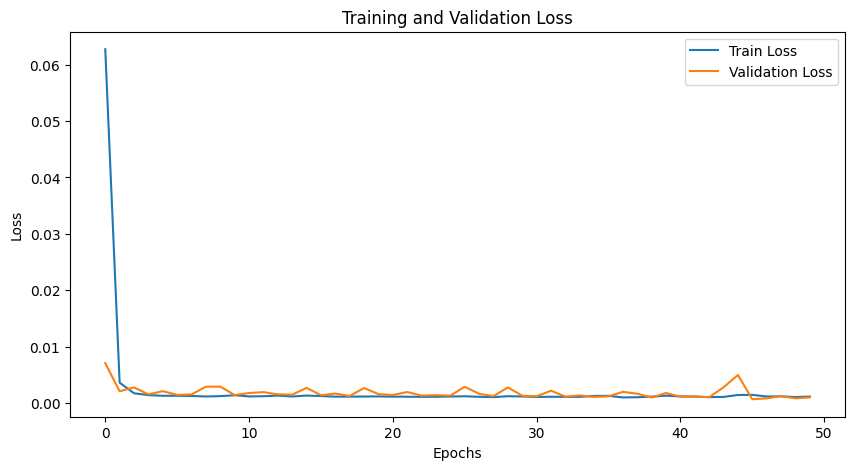

Predicción del precio en los próximos 30 minutos: 200.32
Último precio real (2025-02-04 19:30:00): 202.16
RMSE: 0.0299
MAE: 0.0238


In [129]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 📌 1. Preparación de los Datos (X = Features, Y = Objetivo)
window_size = 30  # Se cambia a 30 minutos

X, Y = [], []
for i in range(len(df_final) - window_size):
    X.append(df_final.iloc[i:i+window_size].values)  # Todas las columnas como entrada
    Y.append(df_final.iloc[i+window_size]['Close'])  # Solo la columna 'Close' como salida

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# 📌 2. División en Entrenamiento y Validación
train_split = 0.8
split = int(len(Y) * train_split)

X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

# 📌 3. Creación de Datasets para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Configuración de hiperparámetros
batch_size = 32
learning_rate = 0.005

# Crear datasets y DataLoaders
train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# 📌 4. Definir la Arquitectura de la LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Usamos solo la última salida de la secuencia

# 📌 5. Instanciar y Configurar el Modelo
input_size = X.shape[2]  # Número de características
model = LSTMModel(input_size).to("cpu")

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 📌 6. Entrenamiento de la LSTM
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            preds = model(X_batch)
            val_loss += criterion(preds.squeeze(), Y_batch).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# 📌 7. Graficar la Pérdida de Entrenamiento y Validación
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 📌 8. Hacer Predicción de los Próximos 30 Minutos (con desnormalización)
model.eval()
latest_X = torch.tensor(X[-1], dtype=torch.float32).unsqueeze(0)  # Última secuencia de entrada
predicted_price = model(latest_X).cpu().detach().numpy().flatten()[0]


# 📌 Solución para desnormalizar correctamente
expanded_prediction = np.zeros((1, X.shape[2]))  # Crear un array de ceros con 26 columnas
expanded_prediction[0, 0] = predicted_price  # Insertar el valor predicho en la primera columna

# Desnormalizar correctamente
predicted_price_real = scaler.inverse_transform(expanded_prediction)[0, 0]  # Extraer solo el precio real

print(f"Predicción del precio en los próximos 30 minutos: {predicted_price_real:.2f}")

# 📌 9. Obtener el último precio real del DataFrame
last_real_price_index = df_final_1.index[-1]  # Última fecha y hora registrada
last_real_price = df_final_1.iloc[-1]['Close']  # Último precio real

print(f"Último precio real ({last_real_price_index}): {last_real_price:.2f}")

# 📌 10. Evaluación del Modelo
preds_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        preds = model(X_batch).cpu().numpy().flatten()
        preds_val.extend(preds)

rmse = np.sqrt(mean_squared_error(Y_val, preds_val))
mae = mean_absolute_error(Y_val, preds_val)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


# Random Search

In [128]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# 📌 1. Rango de hiperparámetros para Random Search
param_grid = {
    "hidden_size": [32, 50, 100, 128],
    "num_layers": [1, 2, 3],
    "dropout": [0.1, 0.2, 0.3, 0.5],
    "batch_size": [32, 64, 128],
    "learning_rate": [0.001, 0.003, 0.005, 0.01]
}

# 📌 2. Definir el número de combinaciones a probar
num_trials = 10
best_val_loss = float("inf")
best_params = None
best_model = None

# 📌 3. Bucle de Random Search
for trial in range(num_trials):
    # Selección aleatoria de hiperparámetros
    hidden_size = random.choice(param_grid["hidden_size"])
    num_layers = random.choice(param_grid["num_layers"])
    dropout = random.choice(param_grid["dropout"])
    batch_size = random.choice(param_grid["batch_size"])
    learning_rate = random.choice(param_grid["learning_rate"])

    print(f"🔄 Probando configuración: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, batch_size={batch_size}, lr={learning_rate}")

    # 📌 4. Preparar los datos con el nuevo batch_size
    train_loader = DataLoader(TimeSeriesDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)

    # 📌 5. Definir la LSTM con los hiperparámetros actuales
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            return self.fc(lstm_out[:, -1, :])

    model = LSTMModel(X.shape[2], hidden_size, num_layers, dropout).to("cpu")

    # 📌 6. Definir la función de pérdida y el optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 📌 7. Entrenamiento del modelo con la configuración actual
    num_epochs = 30
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds.squeeze(), Y_batch)
            loss.backward()
            optimizer.step()

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                preds = model(X_batch)
                val_loss += criterion(preds.squeeze(), Y_batch).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f"🔹 Final val_loss: {val_loss:.6f}")

    # 📌 8. Guardar la mejor configuración
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = (hidden_size, num_layers, dropout, batch_size, learning_rate)
        best_model = model

print(f"✅ Mejor configuración encontrada: hidden_size={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, batch_size={best_params[3]}, lr={best_params[4]}")
print(f"🔹 Mejor val_loss obtenida: {best_val_loss:.6f}")

# 📌 9. Evaluación final con el mejor modelo
best_model.eval()
preds_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        preds = best_model(X_batch).cpu().numpy().flatten()
        preds_val.extend(preds)

rmse = np.sqrt(mean_squared_error(Y_val, preds_val))
mae = mean_absolute_error(Y_val, preds_val)

print(f"✅ Evaluación final del mejor modelo:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


🔄 Probando configuración: hidden_size=128, num_layers=2, dropout=0.2, batch_size=128, lr=0.005
🔹 Final val_loss: 0.001306
🔄 Probando configuración: hidden_size=32, num_layers=3, dropout=0.5, batch_size=32, lr=0.001
🔹 Final val_loss: 0.005368
🔄 Probando configuración: hidden_size=32, num_layers=1, dropout=0.2, batch_size=64, lr=0.001


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.004958
🔄 Probando configuración: hidden_size=32, num_layers=2, dropout=0.3, batch_size=32, lr=0.001
🔹 Final val_loss: 0.002275
🔄 Probando configuración: hidden_size=50, num_layers=1, dropout=0.2, batch_size=64, lr=0.003
🔹 Final val_loss: 0.008915
🔄 Probando configuración: hidden_size=128, num_layers=1, dropout=0.5, batch_size=32, lr=0.005


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.001074
🔄 Probando configuración: hidden_size=32, num_layers=1, dropout=0.1, batch_size=128, lr=0.005


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.006497
🔄 Probando configuración: hidden_size=100, num_layers=1, dropout=0.3, batch_size=128, lr=0.01


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


🔹 Final val_loss: 0.006006
🔄 Probando configuración: hidden_size=32, num_layers=3, dropout=0.1, batch_size=128, lr=0.001
🔹 Final val_loss: 0.002988
🔄 Probando configuración: hidden_size=100, num_layers=1, dropout=0.5, batch_size=32, lr=0.01
🔹 Final val_loss: 0.001327
✅ Mejor configuración encontrada: hidden_size=128, num_layers=1, dropout=0.5, batch_size=32, lr=0.005
🔹 Mejor val_loss obtenida: 0.001074
✅ Evaluación final del mejor modelo:
RMSE: 0.0327
MAE: 0.0274
